# 1. Import The Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# 2. Load The Dataset

In [2]:
csv_file = 'market_basket.csv'
df_binary = pd.read_csv(csv_file)

print("Dataset shape:", df_binary.shape)
df_binary.head(10)

Dataset shape: (790, 11)


,TransactionID,Milk,Bread,Butter,Eggs,Cheese,Chicken,Pasta,Tomato,Rice,Juice
0,1,1,0,0,0,1,0,1,1,1,0
1,2,0,1,0,0,0,0,0,0,1,1
2,3,1,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,1,0,1,0,1
4,5,0,1,0,0,0,1,1,0,0,0
5,6,0,0,0,1,1,0,0,1,0,0
6,7,1,0,0,1,1,0,1,0,0,0
7,8,1,1,1,0,0,0,0,0,0,1
8,9,0,0,0,1,0,0,1,1,0,1
9,10,1,0,0,0,1,0,0,0,1,1


# 3. Encoding with One-Hot Encoding

In [3]:
# Extract item columns (exclude TransactionID)
item_columns = [col for col in df_binary.columns if col != 'TransactionID']

# Create list of transactions (each is a list of items bought)
transactions = []
for _, row in df_binary.iterrows():
    transaction = [item for item in item_columns if row[item] == 1]
    transactions.append(transaction)

# Convert to one-hot encoded format using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("Encoded dataset shape:", df_encoded.shape)
df_encoded.head(10)

Encoded dataset shape: (790, 10)


,Bread,Butter,Cheese,Chicken,Eggs,Juice,Milk,Pasta,Rice,Tomato
0,False,False,True,False,False,False,True,True,True,True
1,True,False,False,False,False,True,False,False,True,False
2,False,False,False,False,False,False,True,False,False,False
3,False,False,False,True,False,True,True,False,False,True
4,True,False,False,True,False,False,False,True,False,False
5,False,False,True,False,True,False,False,False,False,True
6,False,False,True,False,True,False,True,True,False,False
7,True,True,False,False,False,True,True,False,False,False
8,False,False,False,False,True,True,False,True,False,True
9,False,False,True,False,False,True,True,False,True,False


# 4. Run FP-Growth to find Frequent Itemsets

In [4]:
min_support = 0.02

# Run FP-Growth
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

# Add length
frequent_itemsets_fpgrowth['length'] = frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x))

print(f"Found {len(frequent_itemsets_fpgrowth)} frequent itemsets (FP-Growth)")
frequent_itemsets_fpgrowth.sort_values('support', ascending=False).head(15)

Found 112 frequent itemsets (FP-Growth)


,support,itemsets,length
5,0.381013,(Juice),1
0,0.346835,(Milk),1
1,0.331646,(Pasta),1
2,0.325316,(Tomato),1
6,0.306329,(Bread),1
3,0.284810,(Rice),1
7,0.278481,(Chicken),1
4,0.275949,(Cheese),1
9,0.274684,(Butter),1
8,0.256962,(Eggs),1


# 5. Generate Association Rules

In [5]:
min_confidence = 0.3

rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=min_confidence)

rules_fpgrowth['antecedents_str'] = rules_fpgrowth['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_fpgrowth['consequents_str'] = rules_fpgrowth['consequents'].apply(lambda x: ', '.join(list(x)))

print(f"Found {len(rules_fpgrowth)} association rules (FP-Growth)")
rules_fpgrowth[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']] \
    .sort_values('lift', ascending=False).head(15)

Found 131 association rules (FP-Growth)


,antecedents_str,consequents_str,support,confidence,lift
25,"Rice, Juice",Bread,0.075949,0.714286,2.331759
78,"Cheese, Milk",Eggs,0.067089,0.582418,2.266551
77,"Eggs, Milk",Cheese,0.067089,0.609195,2.207635
116,"Pasta, Butter",Chicken,0.068354,0.600000,2.154545
12,"Milk, Juice",Tomato,0.088608,0.686275,2.109560
117,"Pasta, Chicken",Butter,0.068354,0.562500,2.047811
26,"Bread, Juice",Rice,0.075949,0.566038,1.987421
14,"Pasta, Juice",Tomato,0.075949,0.631579,1.941429
118,"Butter, Chicken",Pasta,0.068354,0.606742,1.829488
10,"Tomato, Milk",Juice,0.088608,0.686275,1.801186


# 6. Visualize Frequent Itemsets by Size 

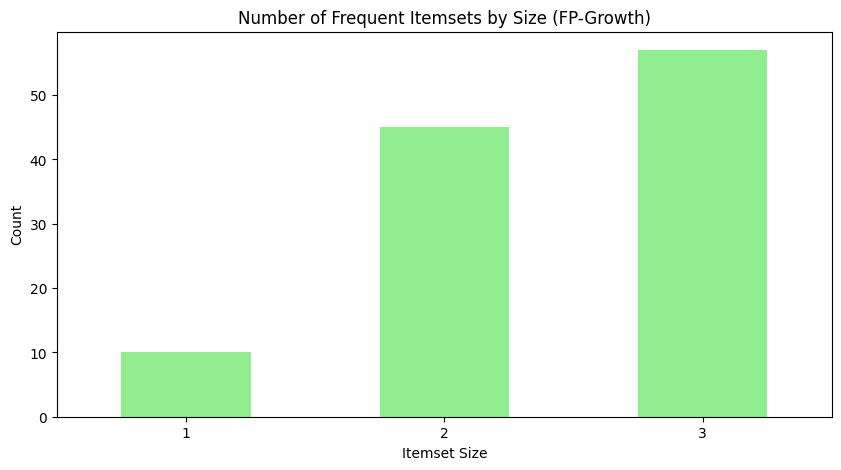

In [6]:
size_counts_fp = frequent_itemsets_fpgrowth['length'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
size_counts_fp.plot(kind='bar', color='lightgreen')
plt.title('Number of Frequent Itemsets by Size (FP-Growth)')
plt.xlabel('Itemset Size')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# 7. Heatmap of Support for 2-Itemsets

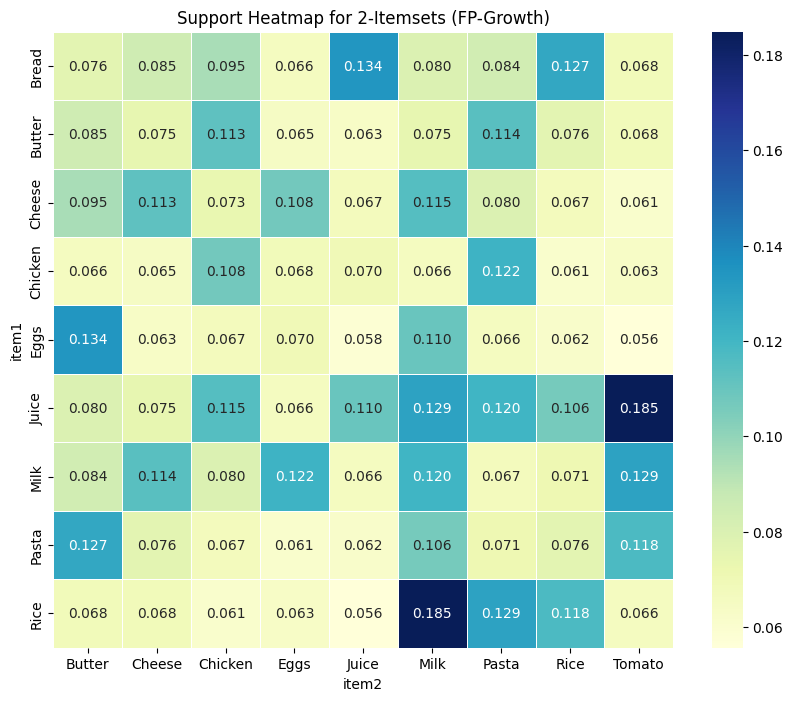

In [7]:
pairs_fp = frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['length'] == 2].copy()

if len(pairs_fp) > 0:
    pairs_fp['item1'] = pairs_fp['itemsets'].apply(lambda x: sorted(x)[0])
    pairs_fp['item2'] = pairs_fp['itemsets'].apply(lambda x: sorted(x)[1])

    heatmap_data_fp = pairs_fp.pivot(index='item1', columns='item2', values='support').fillna(0)
    
    # Make symmetric
    for i in range(len(heatmap_data_fp)):
        for j in range(i+1, len(heatmap_data_fp)):
            val = heatmap_data_fp.iloc[i, j]
            if val > 0:
                heatmap_data_fp.iloc[j, i] = val

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data_fp, annot=True, fmt='.3f', cmap='YlGnBu', linewidths=.5)
    plt.title('Support Heatmap for 2-Itemsets (FP-Growth)')
    plt.show()
else:
    print("No 2-itemsets found with current min_support.")

# 8. Confidence VS Lift

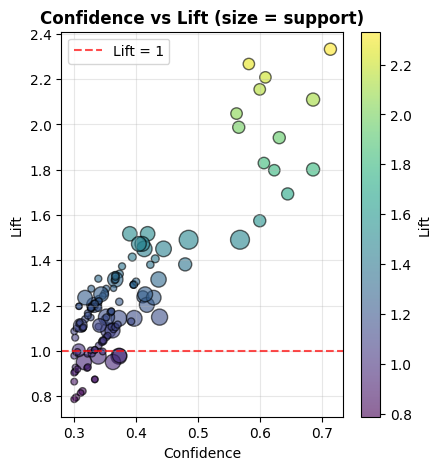

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(rules_fpgrowth['confidence'], rules_fpgrowth['lift'], 
            alpha=0.6, s=rules_fpgrowth['support']*1000, 
            c=rules_fpgrowth['lift'], cmap='viridis', edgecolors='black')
plt.colorbar(label='Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Confidence vs Lift (size = support)', fontweight='bold')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Lift = 1')
plt.legend()
plt.grid(alpha=0.3)